In this project, I will use supervised learning models to identify customers who are likely to churn in the future. Furthermore, I will analyze top factors that influence user retention.

# Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Part 0 loading data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving bank.data.csv to bank.data.csv


In [3]:
churn_df = pd.read_table('bank.data.csv', header = 0, sep = ",")
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Part 1: Data Exploration

### Find any null or wrong type zeros or errors

In [4]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


No nulls

In [5]:
churn_df.eq(0).sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure              413
Balance            3617
NumOfProducts         0
HasCrCard          2945
IsActiveMember     4849
EstimatedSalary       0
Exited             7963
dtype: int64

Zeros are natural, understandble

In [6]:
churn_df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Categorical: Surname, Geography, Gender
consider delete rowNumber and customerId later for training


### Explore Categorical features

<Axes: xlabel='Exited', ylabel='count'>

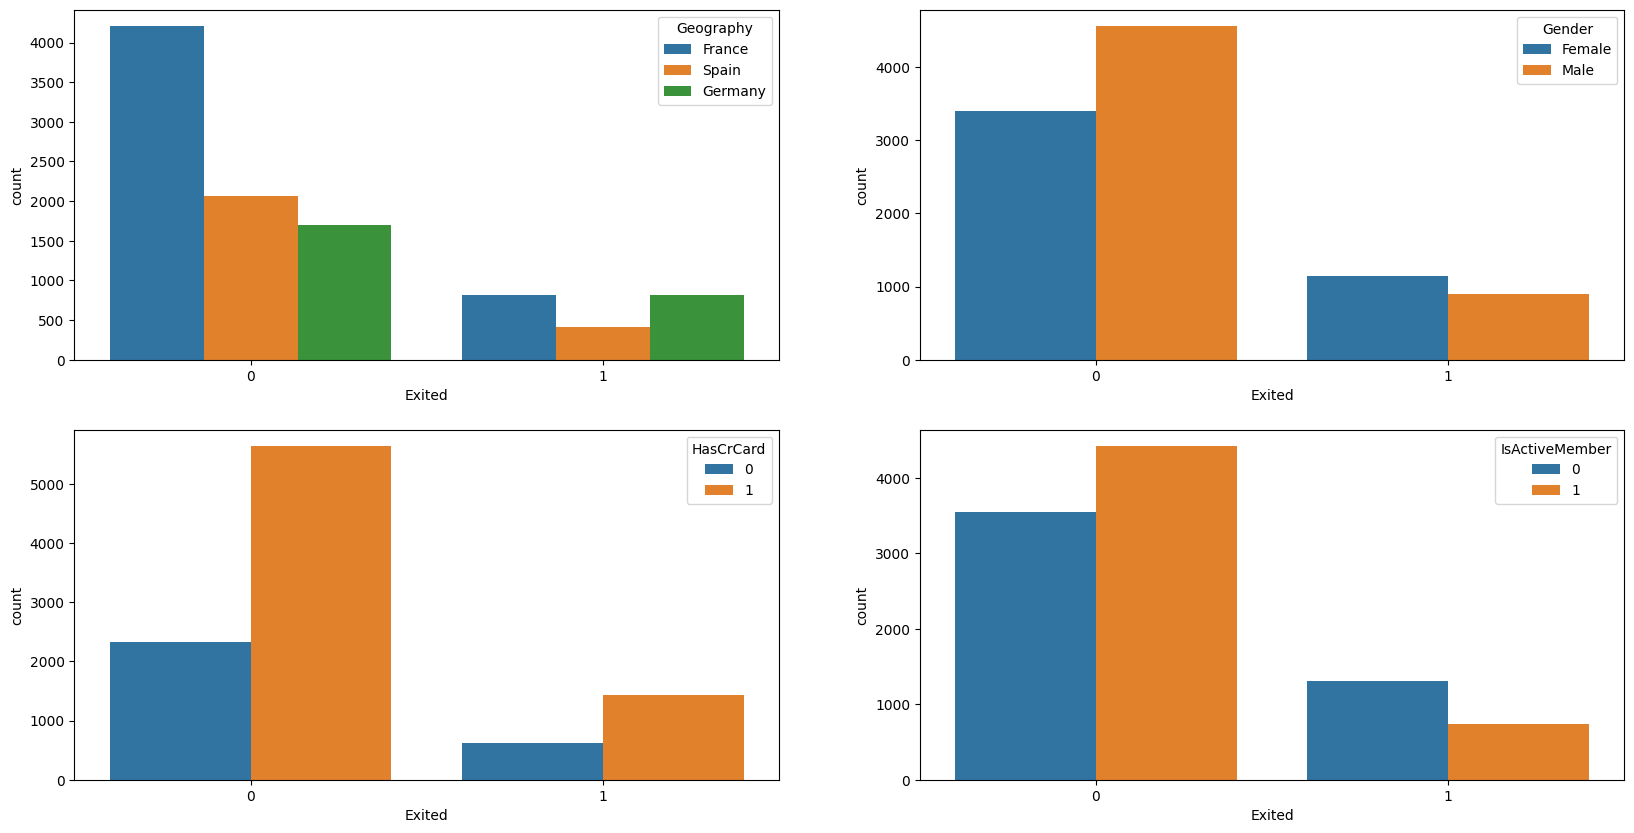

In [7]:
# 'Geography', 'Gender'
# 'HasCrCard', 'IsActiveMember'
_,axss = plt.subplots(2,2, figsize=[20,10])
sns.countplot(x='Exited', hue='Geography', data=churn_df, ax=axss[0][0])
sns.countplot(x='Exited', hue='Gender', data=churn_df, ax=axss[0][1])
sns.countplot(x='Exited', hue='HasCrCard', data=churn_df, ax=axss[1][0])
sns.countplot(x='Exited', hue='IsActiveMember', data=churn_df, ax=axss[1][1])

For Geographic and gender I will do one hot encoding or get dummies

### Numerical feature exploration

In [8]:
correlation = churn_df[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary","HasCrCard","IsActiveMember","Exited"]].corr()
correlation

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,HasCrCard,IsActiveMember,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.001384,-0.005458,0.025651,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.007201,-0.011721,0.085472,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.007784,0.022583,-0.028362,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,0.012797,-0.014858,-0.010084,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.014204,0.003183,0.009612,-0.047820
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,1.000000,-0.009933,-0.011421,0.012097
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,-0.009933,1.000000,-0.011866,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011421,-0.011866,1.000000,-0.156128
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,0.012097,-0.007138,-0.156128,1.000000


<Axes: >

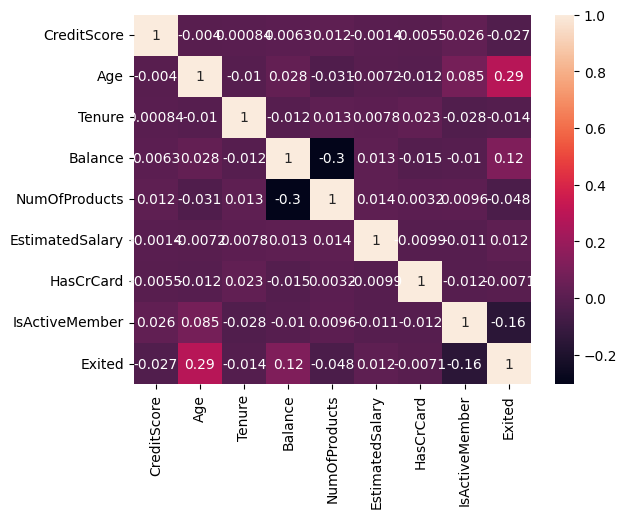

In [9]:
sns.heatmap(correlation, annot=True)

In [10]:
churn_df[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

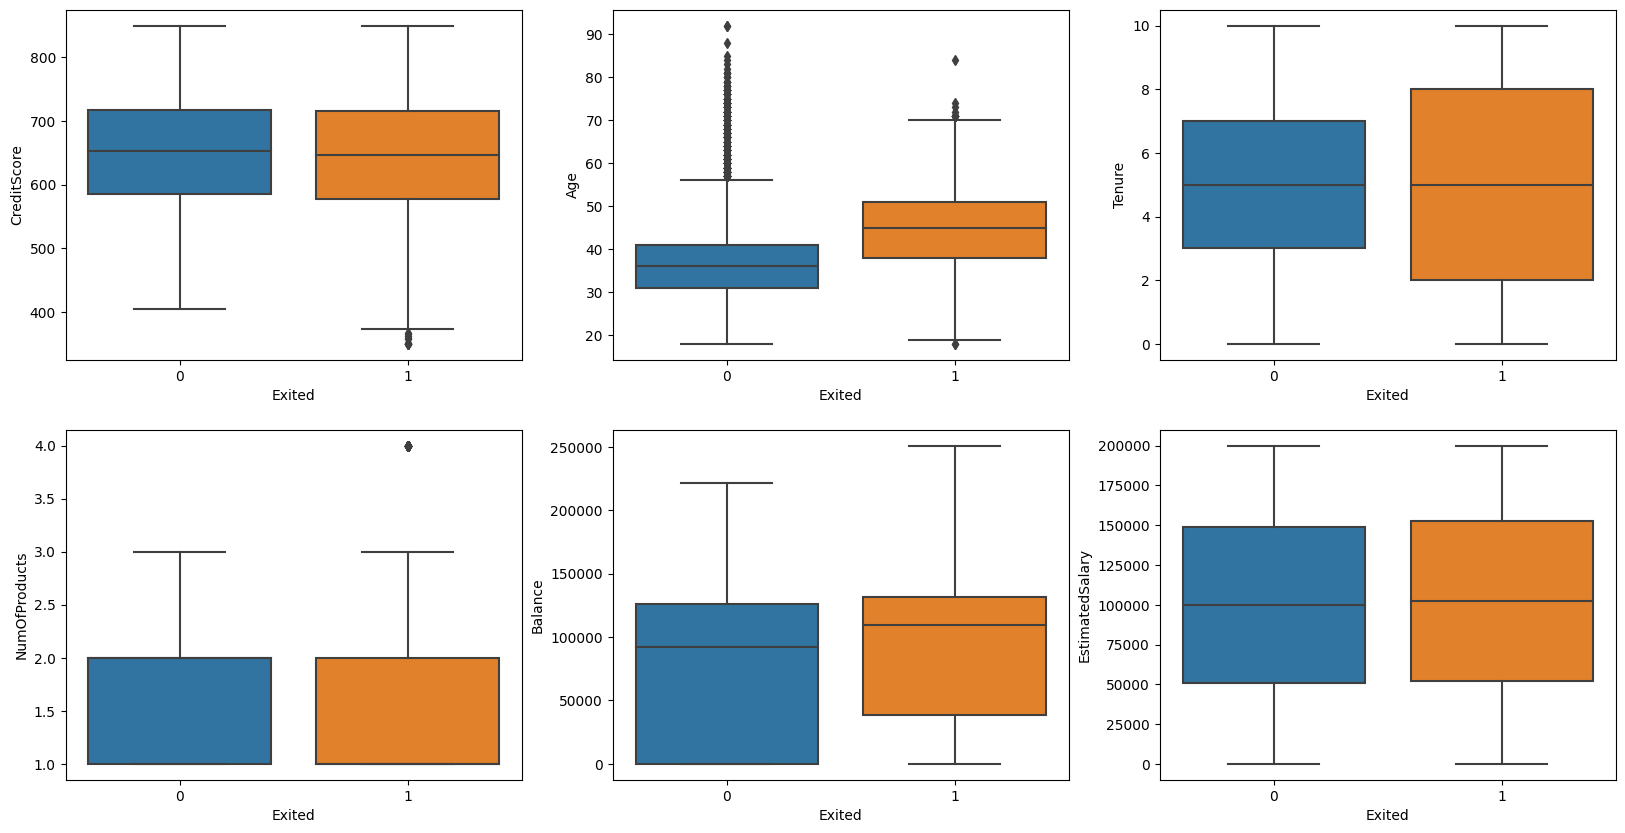

In [11]:
_,axss = plt.subplots(2,3, figsize=[20,10])
sns.boxplot(x='Exited', y ='CreditScore', data=churn_df, ax=axss[0][0])
sns.boxplot(x='Exited', y ='Age', data=churn_df, ax=axss[0][1])
sns.boxplot(x='Exited', y ='Tenure', data=churn_df, ax=axss[0][2])
sns.boxplot(x='Exited', y ='NumOfProducts', data=churn_df, ax=axss[1][0])
sns.boxplot(x='Exited', y ='Balance', data=churn_df, ax=axss[1][1])
sns.boxplot(x='Exited', y ='EstimatedSalary', data=churn_df, ax=axss[1][2])

# Part 2: Data Processing

Drop useless features



In [12]:
temp_df = churn_df.drop(["RowNumber",	"CustomerId",	"Surname"], axis = 1)
temp_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [13]:
temp_df["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Customer Churn is approximatly 20% for churn and 80 for not churn

## Train Test Splitting

In some case for data leakage do test train split first.

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(temp_df, test_size=0.25, random_state = 4)
X_train = train.drop(["Exited"], axis = 1)
X_test = test.drop(["Exited"], axis = 1)
Y_train = train["Exited"]
Y_test = test["Exited"]

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 7500 observation with 10 features
test data has 2500 observation with 10 features


In [15]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
3698,589,France,Female,21,3,0.00,2,0,1,55601.44
4832,617,France,Female,79,7,0.00,1,1,1,160589.18
9178,798,Germany,Female,39,6,119787.76,1,1,1,164248.33
6746,640,Spain,Male,39,3,0.00,1,1,1,105997.25
5774,706,Germany,Male,31,1,117020.08,2,1,0,54439.53


## Transform Categorical features to Numerical

For Geography, more than 3 variables, use one hot encoder

In [16]:
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, enc, categories):
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names_out(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['Geography']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X_train[categories])

X_train = OneHotEncoding(X_train, enc_ohe, categories)
X_test = OneHotEncoding(X_test, enc_ohe, categories)

In [17]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,589,Female,21,3,0.00,2,0,1,55601.44,1.0,0.0,0.0
1,617,Female,79,7,0.00,1,1,1,160589.18,1.0,0.0,0.0
2,798,Female,39,6,119787.76,1,1,1,164248.33,0.0,1.0,0.0
3,640,Male,39,3,0.00,1,1,1,105997.25,0.0,0.0,1.0
4,706,Male,31,1,117020.08,2,1,0,54439.53,0.0,1.0,0.0


For gender only 2 variables, use ordinal encoder

In [18]:

from sklearn.preprocessing import OrdinalEncoder

categories = ['Gender']
enc_oe = OrdinalEncoder()
enc_oe.fit(X_train[categories])

X_train[categories] = enc_oe.transform(X_train[categories])
X_test[categories] = enc_oe.transform(X_test[categories])

In [19]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,589,0.0,21,3,0.00,2,0,1,55601.44,1.0,0.0,0.0
1,617,0.0,79,7,0.00,1,1,1,160589.18,1.0,0.0,0.0
2,798,0.0,39,6,119787.76,1,1,1,164248.33,0.0,1.0,0.0
3,640,1.0,39,3,0.00,1,1,1,105997.25,0.0,0.0,1.0
4,706,1.0,31,1,117020.08,2,1,0,54439.53,0.0,1.0,0.0


## Feature Scalling

Normalization: you are using requires input features to be in a similar range


In [20]:
from sklearn.preprocessing import StandardScaler
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [21]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.645417,0.0,-1.705560,-0.694237,-1.227468,0.808105,-1.553124,0.962053,-0.766237,1.0,0.0,0.0
1,-0.354187,0.0,3.807734,0.688063,-1.227468,-0.912243,0.643864,0.962053,1.057814,1.0,0.0,0.0
2,1.528406,0.0,0.005463,0.342488,0.698494,-0.912243,0.643864,0.962053,1.121388,0.0,1.0,0.0
3,-0.114962,1.0,0.005463,-0.694237,-1.227468,-0.912243,0.643864,0.962053,0.109337,0.0,0.0,1.0
4,0.571508,1.0,-0.754992,-1.385388,0.653995,0.808105,0.643864,-1.039444,-0.786424,0.0,1.0,0.0


# Part 3: Model Training

### Part 3.1 **Logestic** regression and its best hyperparameter

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

parameters = {
    'penalty':('l2','l1'),
    'C':(0.01,0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 10, 100)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear', random_state=4),parameters, cv = 5)
Grid_LR.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=4, solver='liblinear'),
             param_grid={'C': (0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 10, 100),
                         'penalty': ('l2', 'l1')})

Above eussed liblinear, because the size of data is small


###### Write a helper function for printing the best parameter

In [23]:
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))


In [24]:
print_grid_search_metrics(Grid_LR)

Best score: 0.8105333333333334
Best parameters set:
C:0.1
penalty:l1


In [25]:
parameters = {
    'penalty':('l2','l1'),
    'C':(0.01,0.02, 0.04,0.06,0.08,0.1,0.12, 0.15, 0.2)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear',random_state=4),parameters, cv = 5)
Grid_LR.fit(X_train, Y_train)
print_grid_search_metrics(Grid_LR)

Best score: 0.8105333333333334
Best parameters set:
C:0.1
penalty:l1


In [26]:
parameters = {
    'penalty':('l2','l1'),
    'C':(0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear',random_state=4),parameters, cv = 5)
Grid_LR.fit(X_train, Y_train)
print_grid_search_metrics(Grid_LR)

Best score: 0.8105333333333334
Best parameters set:
C:0.1
penalty:l1


In [27]:
best_LR_model = Grid_LR.best_estimator_

### Part 3.2 KNN K nearest Neighbors

In [28]:
from sklearn.neighbors import KNeighborsClassifier
parameters = {
    'n_neighbors':[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31]})

In [29]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.8390666666666666
Best parameters set:
n_neighbors:15


In [30]:
best_KNN_model = Grid_KNN.best_estimator_

### Part 3.3 Random Forest Classification

In [31]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators' : [1, 10 ,20, 30, 40, 50, 60,70, 80,90,100],
    'max_depth': [1,3,5,7,10,15,20,30,40,50,100]
}
Grid_RF = GridSearchCV(RandomForestClassifier(random_state=4),parameters, cv=5)
Grid_RF.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=4),
             param_grid={'max_depth': [1, 3, 5, 7, 10, 15, 20, 30, 40, 50, 100],
                         'n_estimators': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]})

In [32]:
print_grid_search_metrics(Grid_RF)

Best score: 0.8602666666666666
Best parameters set:
max_depth:10
n_estimators:80


In [33]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators' : [1,5,10,20,40,60,70,75,77,79,80,81,82,85,87,90],
    'max_depth': [1,3,5,7,8,9,10,11,12,14,15]
}
Grid_RF = GridSearchCV(RandomForestClassifier(random_state=4),parameters, cv=5)
Grid_RF.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=4),
             param_grid={'max_depth': [1, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15],
                         'n_estimators': [1, 5, 10, 20, 40, 60, 70, 75, 77, 79,
                                          80, 81, 82, 85, 87, 90]})

In [34]:
print_grid_search_metrics(Grid_RF)

Best score: 0.8608
Best parameters set:
max_depth:11
n_estimators:79


In [35]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators' : [73,74,75,76,77,78,79,80,81,82,83,85,86],
    'max_depth': [5,6,7,8,9,10,11,12,13,14,15]
}
Grid_RF = GridSearchCV(RandomForestClassifier(random_state=4),parameters, cv=5)
Grid_RF.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=4),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                         'n_estimators': [73, 74, 75, 76, 77, 78, 79, 80, 81,
                                          82, 83, 85, 86]})

In [36]:
print_grid_search_metrics(Grid_RF)

Best score: 0.8610666666666666
Best parameters set:
max_depth:13
n_estimators:74


In [37]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators' : [70,71,72,73,74,75,76,77,78,79,80,81],
    'max_depth': [9,10,11,12,13,14,15,16,17]
}
Grid_RF = GridSearchCV(RandomForestClassifier(random_state=4),parameters, cv=5)
Grid_RF.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=4),
             param_grid={'max_depth': [9, 10, 11, 12, 13, 14, 15, 16, 17],
                         'n_estimators': [70, 71, 72, 73, 74, 75, 76, 77, 78,
                                          79, 80, 81]})

In [38]:
print_grid_search_metrics(Grid_RF)

Best score: 0.8611999999999999
Best parameters set:
max_depth:17
n_estimators:75


In [39]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators' : [70,71,72,73,74,75,76,77,78,79,80,81],
    'max_depth': [12,13,14,15,16,17,18,19,20,21]
}
Grid_RF = GridSearchCV(RandomForestClassifier(random_state=4),parameters, cv=5)
Grid_RF.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=4),
             param_grid={'max_depth': [12, 13, 14, 15, 16, 17, 18, 19, 20, 21],
                         'n_estimators': [70, 71, 72, 73, 74, 75, 76, 77, 78,
                                          79, 80, 81]})

In [40]:
print_grid_search_metrics(Grid_RF)

Best score: 0.8611999999999999
Best parameters set:
max_depth:17
n_estimators:75


In [41]:
best_RF_model = Grid_RF.best_estimator_

## Part 4 Model Evaluation

#### Part 4.1 Test Scores

###### Logestic regression Test Score

In [42]:
best_LR_model.predict(X_test)
best_LR_model.score(X_test, Y_test)


0.8188

###### KNN K nearest Neighbors Test Score




In [43]:
best_KNN_model.predict(X_test)
best_KNN_model.score(X_test, Y_test)

0.8572

###### Random Forest Classification Test Score

In [44]:
best_RF_model.predict(X_test)
best_RF_model.score(X_test, Y_test)

0.8696

#### Part 4.2 Confusion Matrix (Precision, Recall, Accuracy)

First biuld up helper functions for finding


In [45]:
from sklearn.metrics import confusion_matrix

def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))
    print ()

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)

confusion_matrices = [
    ("Logistic Regression", confusion_matrix(Y_test,best_LR_model.predict(X_test))),
    ("K nearest neighbor", confusion_matrix(Y_test, best_KNN_model.predict(X_test))),
    ("Random Forest", confusion_matrix(Y_test,best_RF_model.predict(X_test))),
]
print(confusion_matrix(Y_test,best_RF_model.predict(X_test)))

[[1922   78]
 [ 248  252]]


In [46]:
draw_confusion_matrices(confusion_matrices)

Logistic Regression
Accuracy is: 0.8188
precision is: 0.6407185628742516
recall is: 0.214

K nearest neighbor
Accuracy is: 0.8572
precision is: 0.8122270742358079
recall is: 0.372

Random Forest
Accuracy is: 0.8696
precision is: 0.7636363636363637
recall is: 0.504



In [47]:
from sklearn.metrics import f1_score

LR_f1 = f1_score(Y_test, best_LR_model.predict(X_test))
print("Logistic Regression F1 score: " + str(LR_f1))

KNN_f1 = f1_score(Y_test, best_KNN_model.predict(X_test))
print("K nearest neighbor F1 score: " + str(KNN_f1))

RF_f1 = f1_score(Y_test, best_RF_model.predict(X_test))
print("Random Forest F1 score: " + str(RF_f1))


Logistic Regression F1 score: 0.32083958020989506
K nearest neighbor F1 score: 0.5102880658436214
Random Forest F1 score: 0.6072289156626507


#### Part 4.3 Model Evaluation - ROC & AUC

###### Logestic Regression - ROC & AUC

In [48]:
best_LR_model.predict_proba(X_test)

array([[0.7941308 , 0.2058692 ],
       [0.84009494, 0.15990506],
       [0.90093877, 0.09906123],
       ...,
       [0.91294583, 0.08705417],
       [0.92217369, 0.07782631],
       [0.79624537, 0.20375463]])

In [49]:
from sklearn.metrics import roc_curve
from sklearn import metrics


y_pred_LR = best_LR_model.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, thresh = roc_curve(Y_test, y_pred_LR)



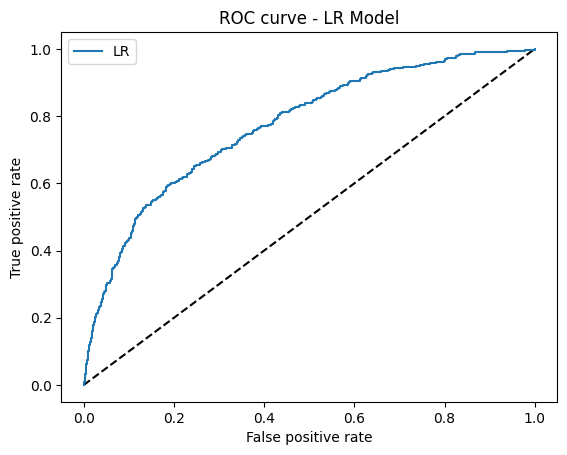

In [50]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [51]:
print("AUC Score:",metrics.auc(fpr_lr,tpr_lr))

AUC Score: 0.7727189999999999


###### KNN - ROC & AUC

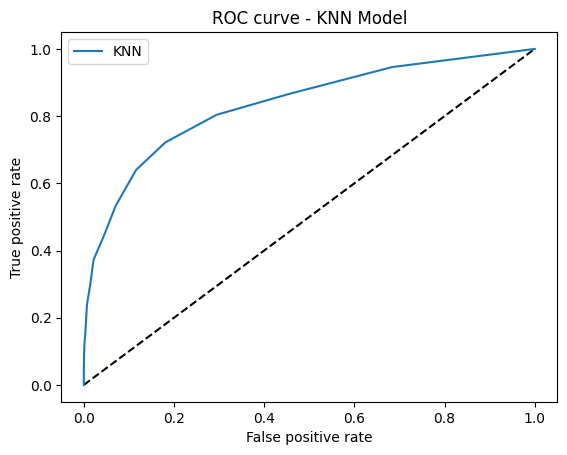

In [52]:

y_pred_KNN = best_KNN_model.predict_proba(X_test)[:,1]
fpr_knn, tpr_knn, thresh_knn = roc_curve(Y_test, y_pred_KNN)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, label='KNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - KNN Model')
plt.legend(loc='best')
plt.show()

In [53]:
print("AUC Score:",metrics.auc(fpr_knn,tpr_knn))

AUC Score: 0.8340835


###### Random Forest - ROC & AUC

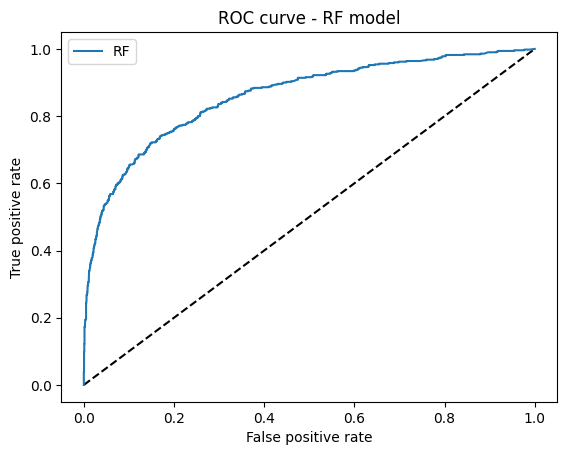

In [54]:
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(Y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()


In [55]:
print("AUC Score:",metrics.auc(fpr_rf,tpr_rf))

AUC Score: 0.8598310000000001


#### Part 4.4 Feature Importance

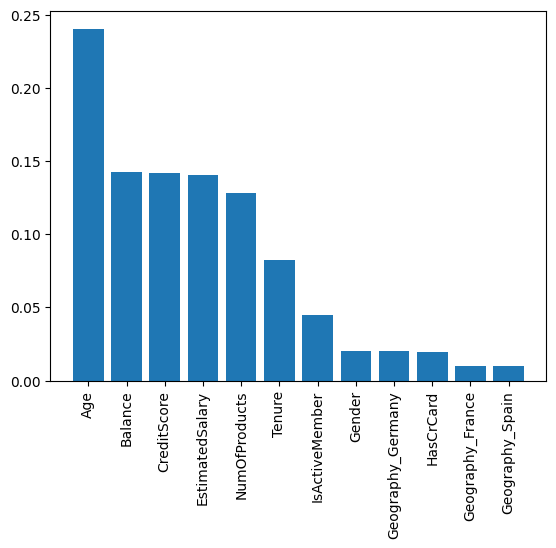

In [56]:

importances = best_RF_model.feature_importances_
feature_name = X_train.columns.values
indices = np.argsort(importances)[::-1]
plt.figure(1)
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()

According to the model training and model evaluation, I found out that Random Forest is the best model here for predicting the potention bank customer churn.
With its performance score:
Random Forest

Accuracy is: 0.8696

precision is: 0.7636363636363637

recall is: 0.504

AUC Score: 0.8598310000000001

Also, I found out that Age is an important feature to determine if the bank customer will exit or not.